In [51]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from dotenv import find_dotenv, load_dotenv
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

In [7]:
df = pd.read_csv("./data/item_data.csv", index_col=0)

In [8]:
df_step = df[df["file_key"].str.lower().str.endswith(("step", "stp"))]

In [14]:
df_step = df_step.dropna().reset_index(drop=True)
df_step.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62170 entries, 0 to 62169
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_id        62170 non-null  int64  
 1   file_name      62170 non-null  object 
 2   file_key       62170 non-null  object 
 3   quantity       62170 non-null  int64  
 4   technology     62170 non-null  object 
 5   technology_id  62170 non-null  object 
 6   area           62170 non-null  float64
 7   depth          62170 non-null  float64
 8   width          62170 non-null  float64
 9   height         62170 non-null  float64
 10  volume         62170 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 5.2+ MB


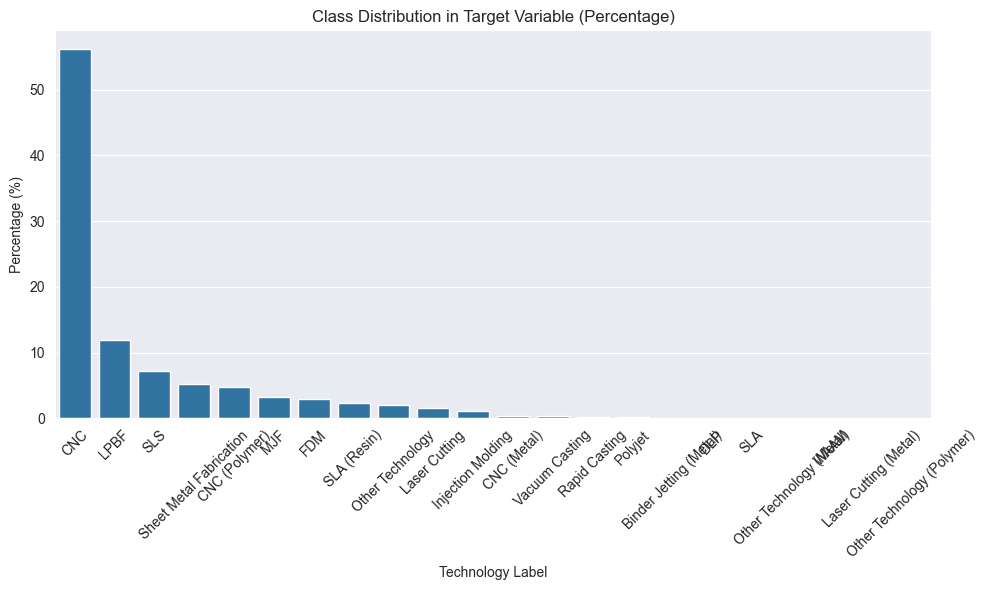

technology
CNC                            56.2 %
LPBF                          11.99 %
SLS                            7.15 %
Sheet Metal Fabrication         5.2 %
CNC (Polymer)                  4.71 %
MJF                            3.22 %
FDM                             3.0 %
SLA (Resin)                     2.4 %
Other Technology               2.07 %
Laser Cutting                  1.57 %
Injection Molding              1.09 %
CNC (Metal)                     0.4 %
Vacuum Casting                 0.33 %
Rapid Casting                  0.28 %
Polyjet                        0.14 %
Binder Jetting (Metal)         0.12 %
DLP                            0.05 %
SLA                            0.03 %
Other Technology (Metal)       0.02 %
WAAM                           0.02 %
Laser Cutting (Metal)          0.01 %
Other Technology (Polymer)      0.0 %
Name: proportion, dtype: object


In [16]:
# Count the number of samples per class
label_counts = df_step['technology'].value_counts(normalize=True).sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.ylabel("Percentage (%)")
plt.xlabel("Technology Label")
plt.title("Class Distribution in Target Variable (Percentage)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print exact percentages
print(label_counts.round(2).astype(str) + " %")


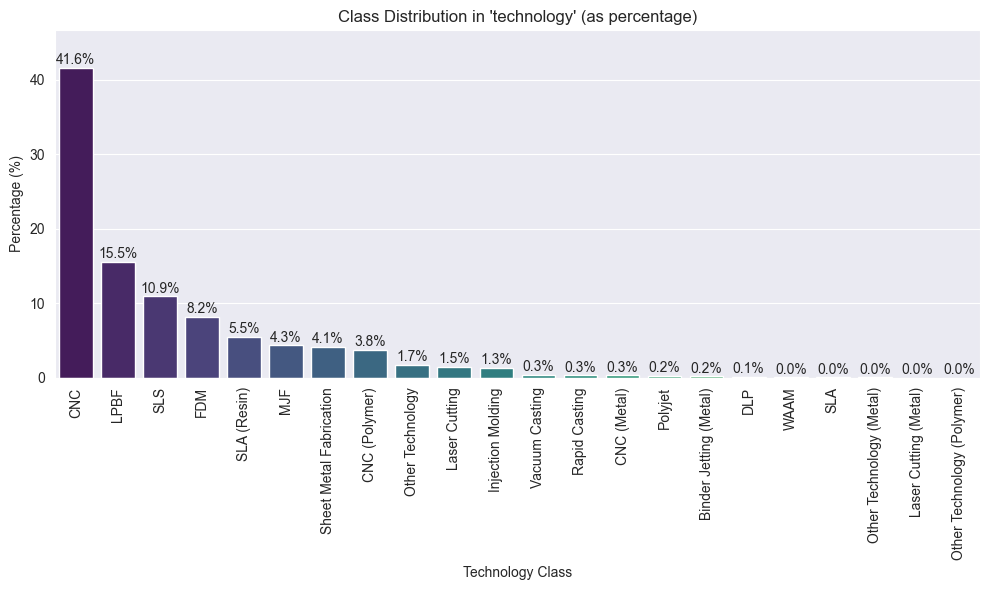

In [23]:
# Percentage of each class
class_percentages = df_step['technology'].value_counts(normalize=True).sort_index().sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_percentages.index, y=class_percentages.values, hue=class_percentages.index, palette="viridis", legend=False)

plt.title("Class Distribution in 'technology' (as percentage)")
plt.ylabel("Percentage (%)")
plt.xlabel("Technology Class")
plt.xticks(rotation=90)
plt.ylim(0, class_percentages.max() + 5)

# Annotate bars with percentage values
for index, value in enumerate(class_percentages.values):
    plt.text(index, value + 0.5, f"{value:.1f}%", ha='center')

plt.tight_layout()
plt.show()


In [32]:
# For the baseline model ,we will drop classes below a threshold of 1%
classes_to_keep = class_percentages[class_percentages >= 1].index.tolist()

# Filter the DataFrame to keep only the selected classes
df_filtered = df_step[df_step['technology'].isin(classes_to_keep)].reset_index(drop=True)
df_filtered.technology.value_counts()

technology
CNC                        36714
LPBF                       13699
SLS                         9606
FDM                         7227
SLA (Resin)                 4860
MJF                         3830
Sheet Metal Fabrication     3654
CNC (Polymer)               3326
Other Technology            1470
Laser Cutting               1313
Injection Molding           1145
Name: count, dtype: int64

In [39]:
# Encode the labels
le = LabelEncoder()
df_filtered['label'] = le.fit_transform(df_filtered['technology'])
# Save the encoder
joblib.dump(le, "./models/label_encoder.pkl")

['./models/label_encoder.pkl']

In [50]:
features = ["area", "width", "height", "depth", "volume"]
X = df_filtered[features]
y = df_filtered['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Train XGBoost model
model_baseline = XGBClassifier(
    objective="multi:softprof",
    num_class=len(df_filtered['label'].unique()),
    random_state=42,
    eval_metric="mlogloss",
    n_estimators=100,
)
model_baseline.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=11, ...)

In [52]:
y_pred = model_baseline.predict(X_test)
y_prob = model_baseline.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
top3 = top_k_accuracy_score(y_test, y_prob, k=3)

print("🔹 Baseline Model (No Sample Weights)")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"Top-3 Accuracy: {top3:.4f}")

🔹 Baseline Model (No Sample Weights)
Accuracy: 0.6056
F1 Score (Macro): 0.4780
Top-3 Accuracy: 0.8402


In [43]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train  # numeric class labels
)